# All original features" sequence logo

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model, load_model
import json
from joblib import load

import sys
sys.path.append("../")
from src.figutils import oh_2_str, extract_str_patches
import src.sequence_logo as sequence_logo
from src.sequence_logo import plot_logo
import src.quad_model

/Users/nnguyen/anaconda3/envs/vis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load pretrained model
model_file_name = f"../model/custom_adjacency_regularizer_20210731_124_step3.h5"
model = load_model(model_file_name)

# Weights
incl_weights, _ = model.get_layer("qc_incl").weights
skip_weights, _ = model.get_layer("qc_skip").weights

In [3]:
# Filter groups
with open("../data/model_data.json", "r") as f:
    model_data = json.load(f)
    INCL_SEQ_GROUPS = model_data["incl_seq_groups"]
    SKIP_SEQ_GROUPS = model_data["skip_seq_groups"]
    
# Sequence logo
seq_logo_data = np.load("../data/seq_logo_data.npy")

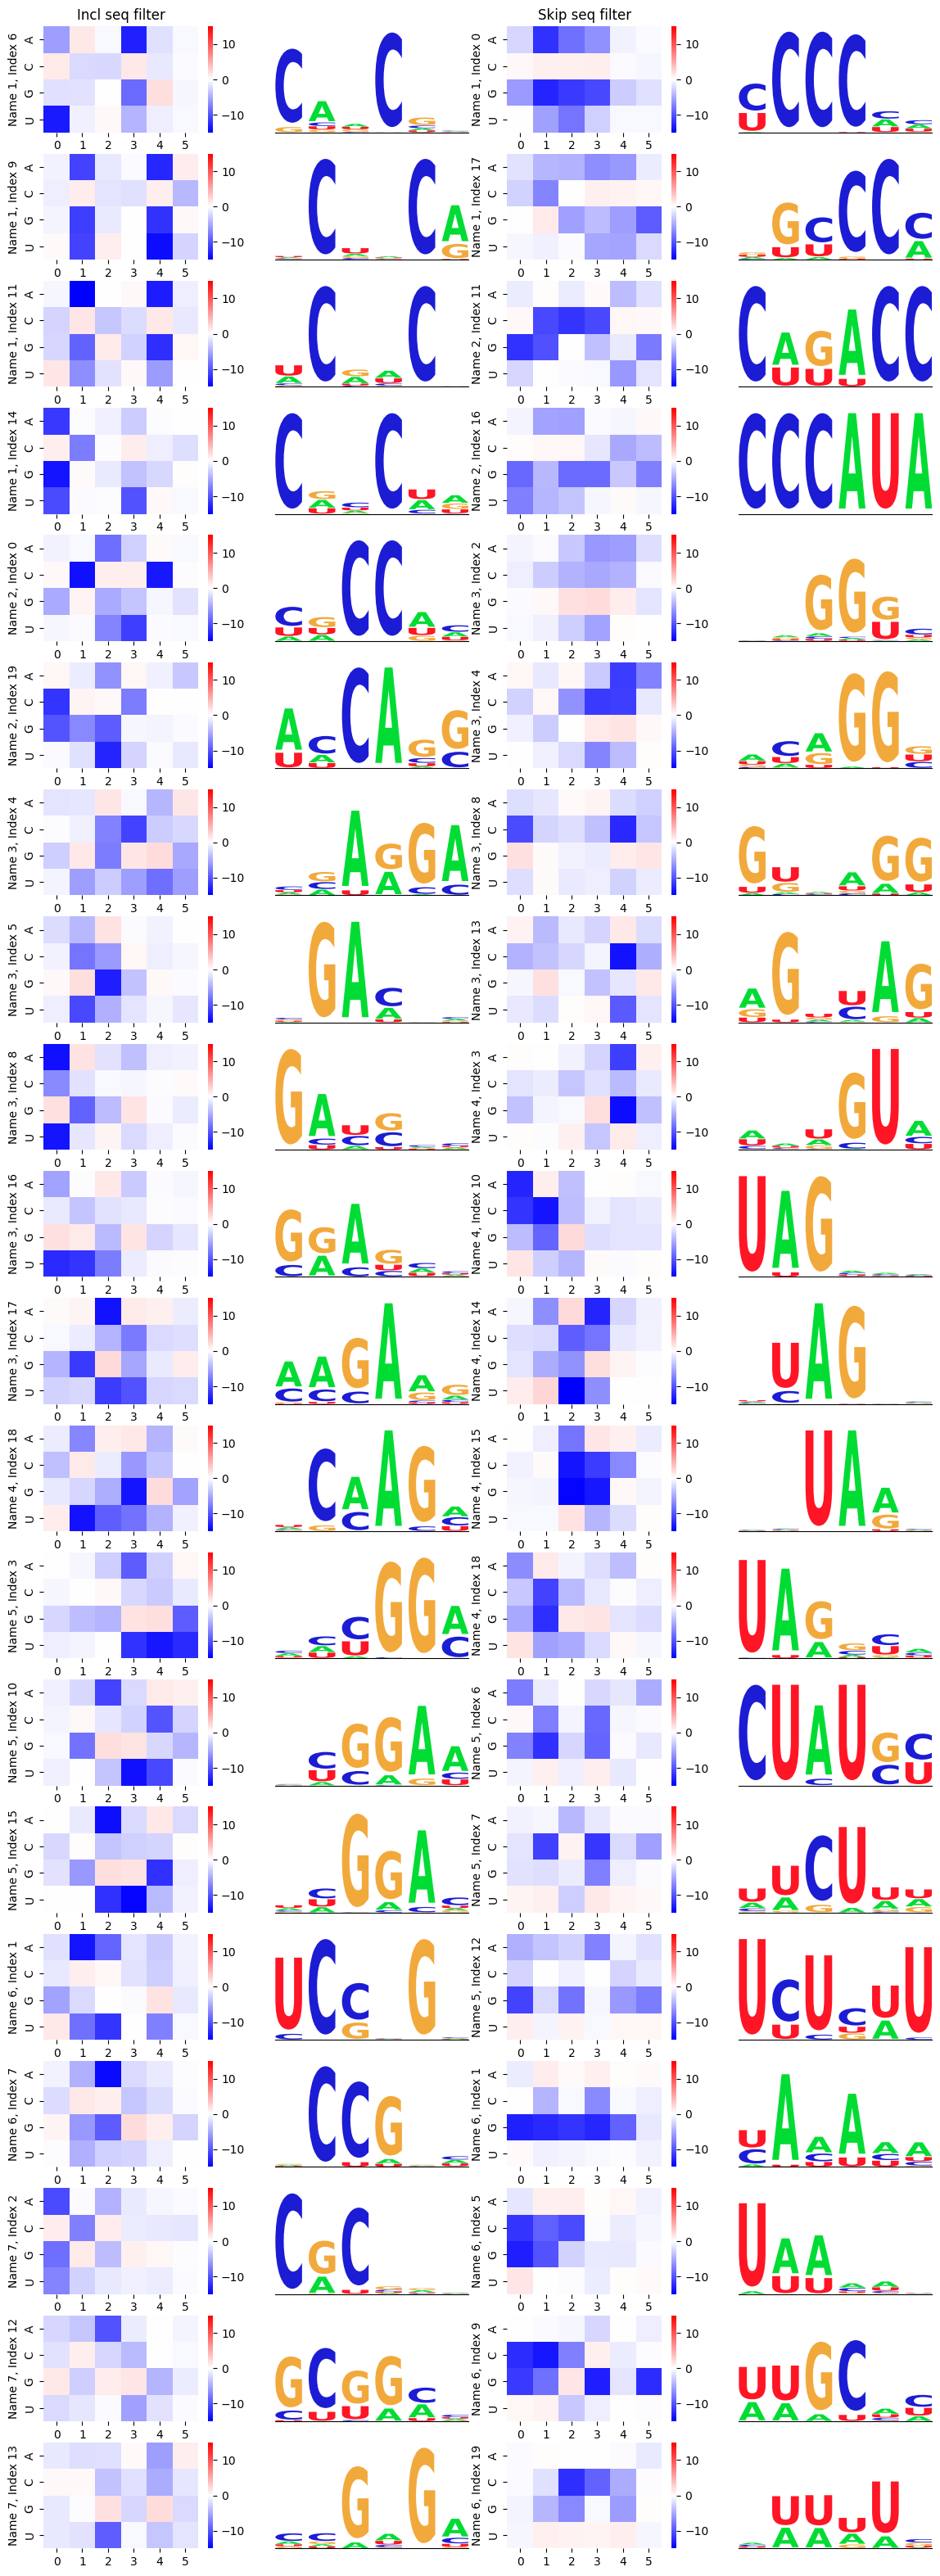

In [10]:
# All sequence logo
nts = ["A", "C", "G", "U"]
num_seq_filters = model.get_layer("qc_incl").kernel.shape[2]
fig, axes = plt.subplots(num_seq_filters, 4, figsize=(14, num_seq_filters * 2))

row = 0
axes[0,0].set_title("Incl seq filter")
for incl_filter_name in sorted(INCL_SEQ_GROUPS.keys()):
    for i in INCL_SEQ_GROUPS[incl_filter_name]:
        sns.heatmap(data=incl_weights[...,i].numpy().T, ax=axes[row,0], cmap="bwr", vmin=-15, vmax=15)
        axes[row,0].set_yticklabels(nts)
        axes[row,0].set_ylabel(f"Name {incl_filter_name}, Index {i}")
        
        data = pd.DataFrame(seq_logo_data[0,i,...], columns=nts)
        plot_logo(data=data, ax=axes[row,1])
        axes[row, 1].set_ylim((0, 2))
        axes[row, 1].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        axes[row, 1].spines["top"].set_visible(False)
        axes[row, 1].spines["right"].set_visible(False)
        axes[row, 1].spines["left"].set_visible(False)
        row += 1

row = 0
axes[0,2].set_title("Skip seq filter")
for skip_filter_name in sorted(SKIP_SEQ_GROUPS.keys()):
    for i in SKIP_SEQ_GROUPS[skip_filter_name]:
        sns.heatmap(data=skip_weights[...,i].numpy().T, ax=axes[row,2], cmap="bwr", vmin=-15, vmax=15)
        axes[row,2].set_yticklabels(nts)
        axes[row,2].set_ylabel(f"Name {skip_filter_name}, Index {i}")
        
        data = pd.DataFrame(seq_logo_data[1,i,...], columns=nts)
        plot_logo(data=data, ax=axes[row,3])
        axes[row, 3].set_ylim((0, 2))
        axes[row, 3].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        axes[row, 3].spines["top"].set_visible(False)
        axes[row, 3].spines["right"].set_visible(False)
        axes[row, 3].spines["left"].set_visible(False)
        row += 1

fig.savefig("../figures/all_sequence_features.png", dpi=300)

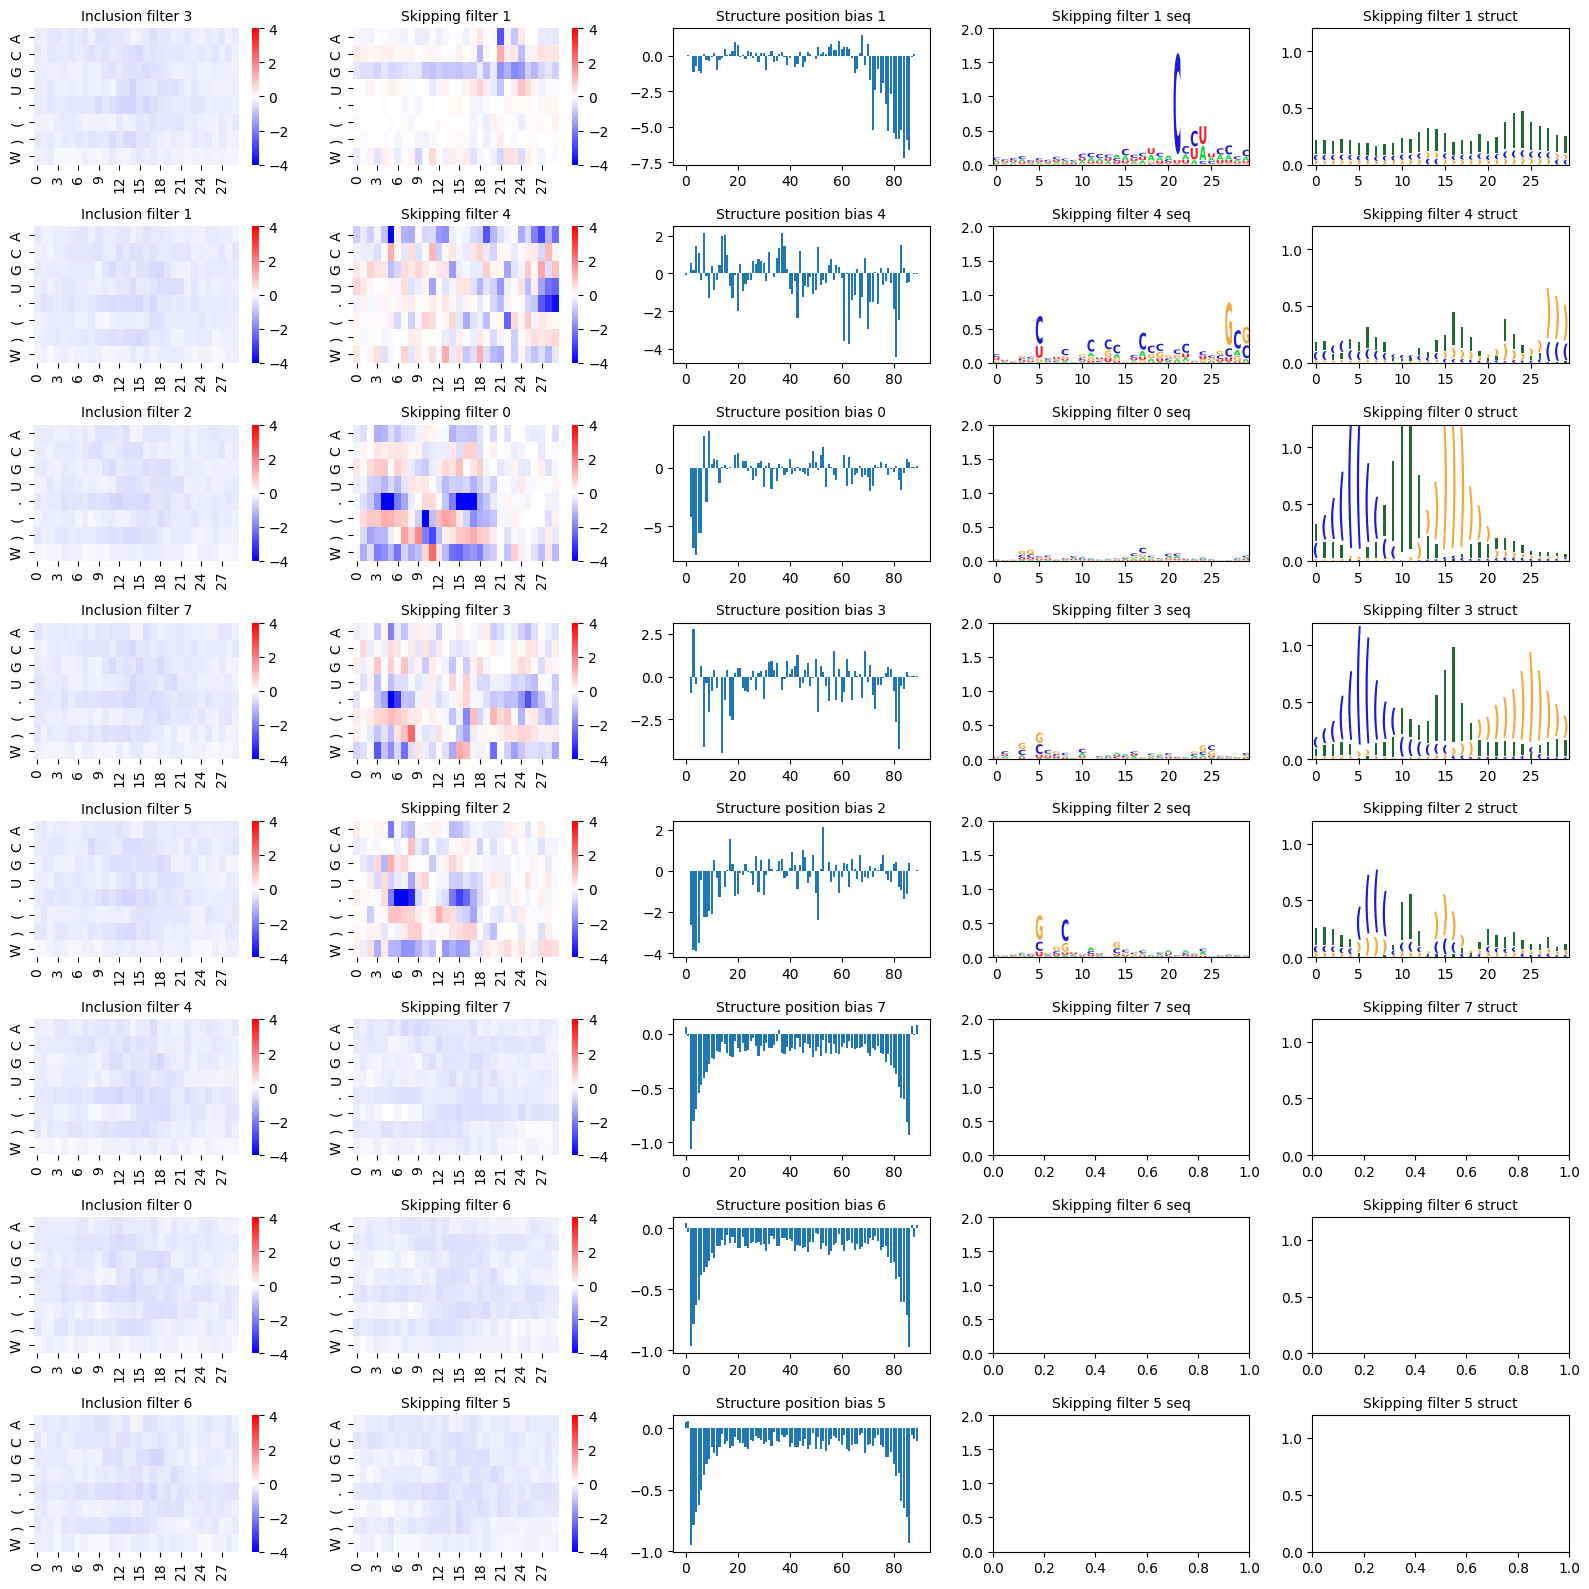

In [5]:
xTr = load(f"../data/xTr_ES7_HeLa_ABC.pkl.gz")

num_seq_filters = model.get_layer("qc_incl").kernel.shape[2]
num_struct_filters = model.get_layer('c_incl_struct').kernel.shape[2]
struct_filter_width = model.get_layer("c_incl_struct").kernel.shape[0]
input_length = model.input[0].shape[1]

left_struct_pad = (struct_filter_width - 1) // 2
right_struct_pad = struct_filter_width - 1 - left_struct_pad
struct_left_cutoff = left_struct_pad - 2
struct_right_cutoff = right_struct_pad - 3

structure_out_model = Model(inputs=model.inputs, outputs=[
    model.get_layer("activation_2").output,
    model.get_layer("activation_3").output
])

incl_conv_W, incl_conv_b = model.get_layer('c_incl_struct').weights
skip_conv_W, skip_conv_b = model.get_layer('c_skip_struct').weights

N = 1000
xTr_subset = [xTr[0][:N], xTr[1][:N], xTr[2][:N]]
incl_acts, skip_acts = structure_out_model.predict(xTr_subset, verbose=0, batch_size=20)

incl_order = np.argsort(incl_acts[..., num_seq_filters:].sum(axis=1).mean(axis=0))[::-1]
skip_order = np.argsort(skip_acts[..., num_seq_filters:].sum(axis=1).mean(axis=0))[::-1]

xTr_subset_nt = oh_2_str(xTr_subset[0], kind='seq')
A = extract_str_patches(xTr_subset_nt, struct_filter_width)
B = [(c, *d) for a, b in zip(
    A, skip_acts[:, struct_left_cutoff:-struct_right_cutoff, num_seq_filters:])
     for c, d in zip(a, b)]
acts_df = pd.DataFrame(B,
                       columns=['input'] +
                       [f'f{i}' for i in range(num_struct_filters)])

xTr_struct_subset_nt = oh_2_str(xTr_subset[1], kind='struct')
As = extract_str_patches(xTr_struct_subset_nt, struct_filter_width)
Bs = [(c, *d) for a, b in zip(
    As, skip_acts[:, struct_left_cutoff:-struct_right_cutoff,
                  num_seq_filters:]) for c, d in zip(a, b)]
acts_df_struct = pd.DataFrame(Bs,
                              columns=['input'] +
                              [f'f{i}' for i in range(num_struct_filters)])

fig, axarr = plt.subplots(num_struct_filters,
                          5,
                          figsize=(16, 16),
                          dpi=100,
                          sharex=False,
                          sharey=False)

M = model.get_layer('position_bias_skip_struct').kernel.numpy()
for i in range(num_struct_filters):
    sns.heatmap(incl_conv_W[..., incl_order[i]].numpy().T,
                cmap='bwr',
                ax=axarr[i, 0],
                vmin=-4,
                vmax=4)
    axarr[i, 0].set_yticks(np.arange(8) + 0.5)
    axarr[i, 0].set_yticklabels(("A", "C", "G", "U", ".", "(", ")", "W"),
                                fontsize=10)
    axarr[i, 0].set_title(f'Inclusion filter {incl_order[i]}', fontsize=10)

    sns.heatmap(skip_conv_W[..., skip_order[i]].numpy().T,
                cmap='bwr',
                ax=axarr[i, 1],
                vmin=-4,
                vmax=4)
    axarr[i, 1].set_yticks(np.arange(8) + 0.5)
    axarr[i, 1].set_yticklabels(("A", "C", "G", "U", ".", "(", ")", "W"),
                                fontsize=10)
    axarr[i, 1].set_title(f'Skipping filter {skip_order[i]}', fontsize=10)
    
    axarr[i, 2].bar(range(input_length), M[:, skip_order[i]])
    axarr[i, 2].set_title(f'Structure position bias {skip_order[i]}', fontsize=10)
    
    df = acts_df[['input', f'f{skip_order[i]}']]
    df.columns = ['input', 'activation']
    df = df.reset_index()
    sequence_logo.plot_logo(df, 2, axarr[i, 3])
    axarr[i, 3].set_ylim(0, 2)
    axarr[i, 3].set_title(f'Skipping filter {skip_order[i]} seq', fontsize=10)
    
    dfS = acts_df_struct[['input', f'f{skip_order[i]}']]
    dfS.columns = ['input', 'activation']
    dfS = dfS.reset_index(drop=True)
    sequence_logo.plot_logo(dfS, 1, axarr[i, 4], nts=['.', '(', ')'], color_map={".": "#1f6933", "(": "#1c1cd5", ")": "#f2a93c"})
    axarr[i, 4].set_ylim(0, 1.2)
    axarr[i, 4].set_title(f'Skipping filter {skip_order[i]} struct', fontsize=10)
    

plt.tight_layout()

In [12]:
struct_left_cutoff, struct_right_cutoff

(12, 12)

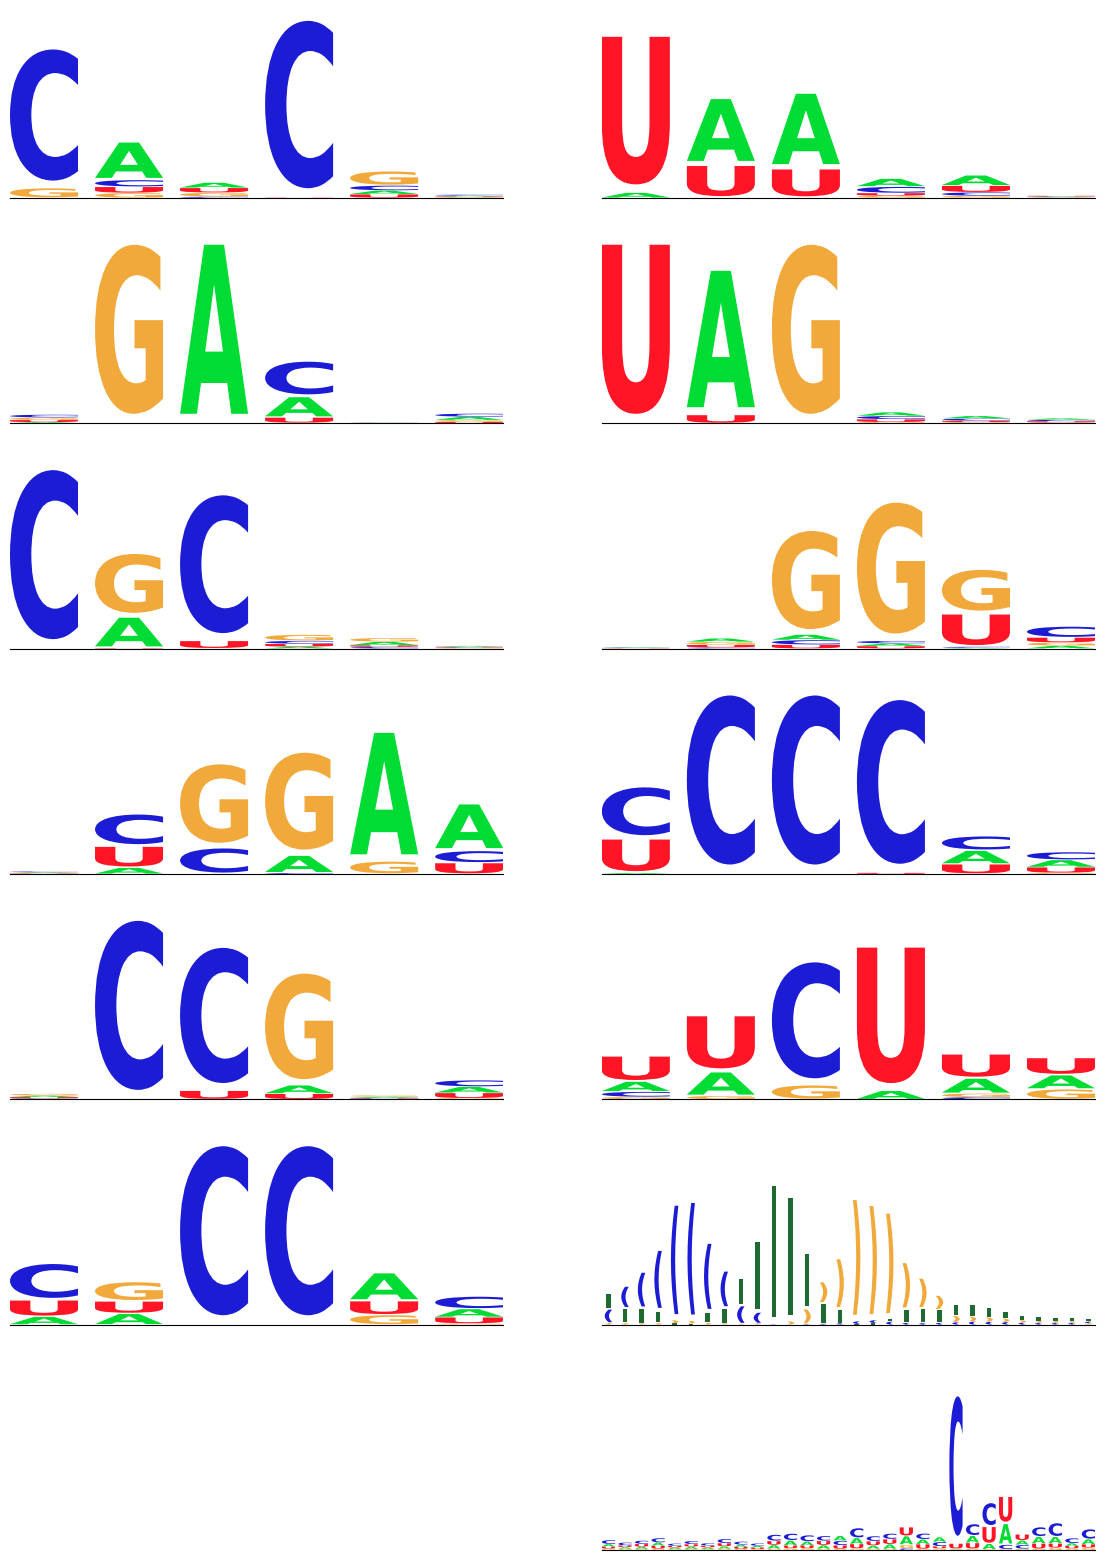

In [45]:
fig, axes = plt.subplots(7, 2, figsize=(14, 20))

lst = [
    (0, 0, 0, 6), (0, 1, 1, 5),
    (1, 0, 0, 5), (1, 1, 1, 10),
    (2, 0, 0, 2), (2, 1, 1, 2),
    (3, 0, 0, 10),(3, 1, 1, 0),
    (4, 0, 0, 7), (4, 1, 1, 7),
    (5, 0, 0, 0),
]

for row, col, cat, ind in lst:
    data = pd.DataFrame(seq_logo_data[cat,ind,...], columns=nts)
    plot_logo(data=data, ax=axes[row,col])
    axes[row,col].set_ylim((0, 2))
    axes[row,col].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
    axes[row,col].spines["top"].set_visible(False)
    axes[row,col].spines["right"].set_visible(False)
    axes[row,col].spines["left"].set_visible(False)

df = acts_df[['input', f'f{skip_order[0]}']]
df.columns = ['input', 'activation']
df = df.reset_index()
sequence_logo.plot_logo(df, 2, axes[6,1])
axes[6,1].set_ylim(0, 2)
axes[6,1].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
axes[6,1].spines["top"].set_visible(False)
axes[6,1].spines["right"].set_visible(False)
axes[6,1].spines["left"].set_visible(False)

dfS = acts_df_struct[['input', f'f{skip_order[2]}']]
dfS.columns = ['input', 'activation']
dfS = dfS.reset_index(drop=True)
sequence_logo.plot_logo(dfS, 1, axes[5,1], nts=['.', '(', ')'], color_map={".": "#1f6933", "(": "#1c1cd5", ")": "#f2a93c"})
axes[5,1].set_ylim(0, 2)
axes[5,1].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
axes[5,1].spines["top"].set_visible(False)
axes[5,1].spines["right"].set_visible(False)
axes[5,1].spines["left"].set_visible(False)

axes[6,0].axis("off")

fig.savefig("../figures/feature_legend.png", dpi=300)

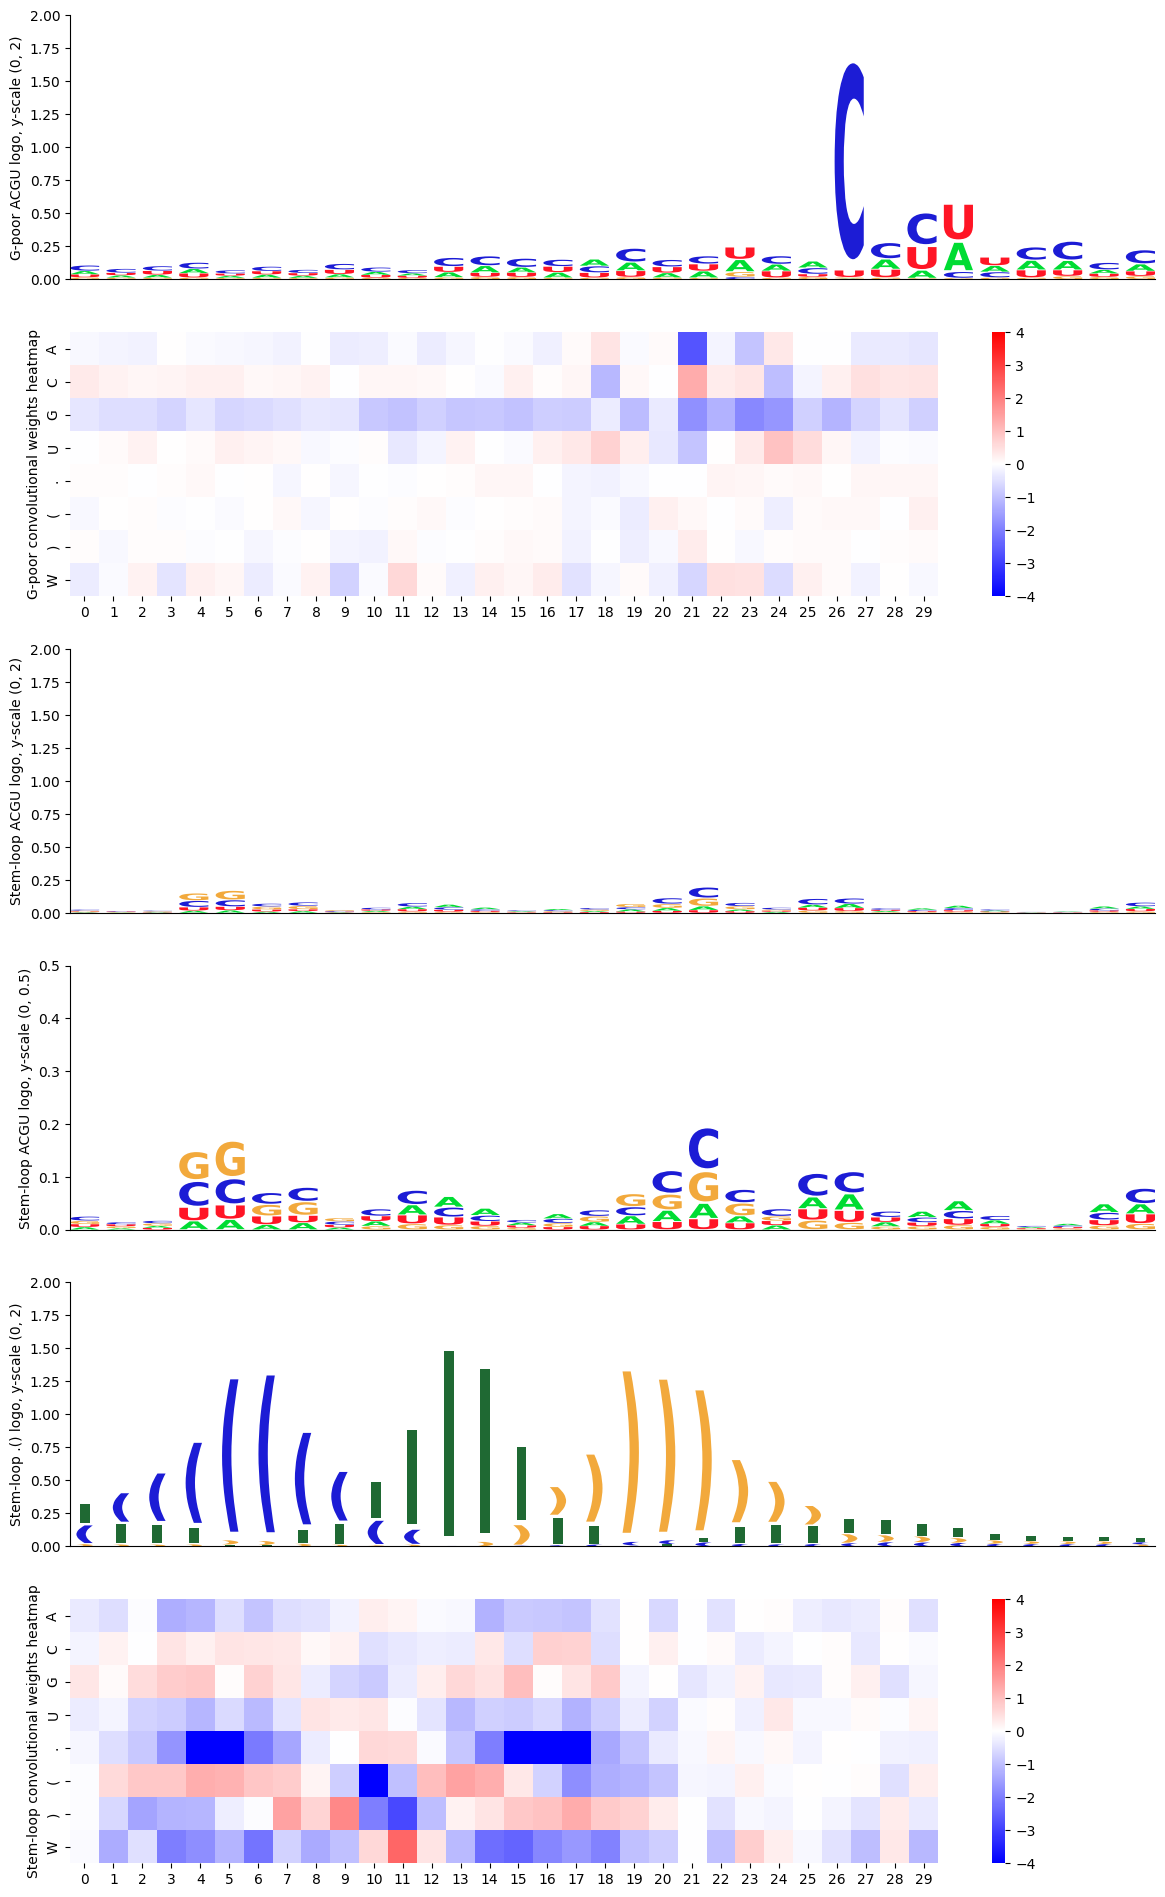

In [35]:
fig, axes = plt.subplots(6, 1, figsize=(14, 24))

df = acts_df[['input', f'f{skip_order[0]}']]
df.columns = ['input', 'activation']
df = df.reset_index()
sequence_logo.plot_logo(df, 2, axes[0])
axes[0].set_ylim(0, 2)
axes[0].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].spines["left"].set_visible(True)
axes[0].set_ylabel("G-poor ACGU logo, y-scale (0, 2)")


sns.heatmap(skip_conv_W[..., skip_order[0]].numpy().T,
            cmap='bwr',
            ax=axes[1],
            vmin=-4,
            vmax=4)
axes[1].set_yticks(np.arange(8) + 0.5)
axes[1].set_yticklabels(("A", "C", "G", "U", ".", "(", ")", "W"))
axes[1].set_ylabel(f'G-poor convolutional weights heatmap')


df = acts_df[['input', f'f{skip_order[2]}']]
df.columns = ['input', 'activation']
df = df.reset_index()
sequence_logo.plot_logo(df, 2, axes[2])
axes[2].set_ylim(0, 2)
axes[2].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[2].spines["top"].set_visible(False)
axes[2].spines["right"].set_visible(False)
axes[2].spines["left"].set_visible(True)
axes[2].set_ylabel("Stem-loop ACGU logo, y-scale (0, 2)")

df = acts_df[['input', f'f{skip_order[2]}']]
df.columns = ['input', 'activation']
df = df.reset_index()
sequence_logo.plot_logo(df, 2, axes[3])
axes[3].set_ylim(0, 0.5)
axes[3].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[3].spines["top"].set_visible(False)
axes[3].spines["right"].set_visible(False)
axes[3].spines["left"].set_visible(True)
axes[3].set_ylabel("Stem-loop ACGU logo, y-scale (0, 0.5)")

dfS = acts_df_struct[['input', f'f{skip_order[2]}']]
dfS.columns = ['input', 'activation']
dfS = dfS.reset_index(drop=True)
sequence_logo.plot_logo(dfS, 1, axes[4], nts=['.', '(', ')'], color_map={".": "#1f6933", "(": "#1c1cd5", ")": "#f2a93c"})
axes[4].set_ylim(0, 2)
axes[4].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[4].spines["top"].set_visible(False)
axes[4].spines["right"].set_visible(False)
axes[4].spines["left"].set_visible(True)
axes[4].set_ylabel("Stem-loop .() logo, y-scale (0, 2)")


sns.heatmap(skip_conv_W[..., skip_order[2]].numpy().T,
            cmap='bwr',
            ax=axes[5],
            vmin=-4,
            vmax=4)
axes[5].set_yticks(np.arange(8) + 0.5)
axes[5].set_yticklabels(("A", "C", "G", "U", ".", "(", ")", "W"))
axes[5].set_ylabel(f'Stem-loop convolutional weights heatmap')

fig.savefig("../figures/long_features_rep.png", dpi=300)

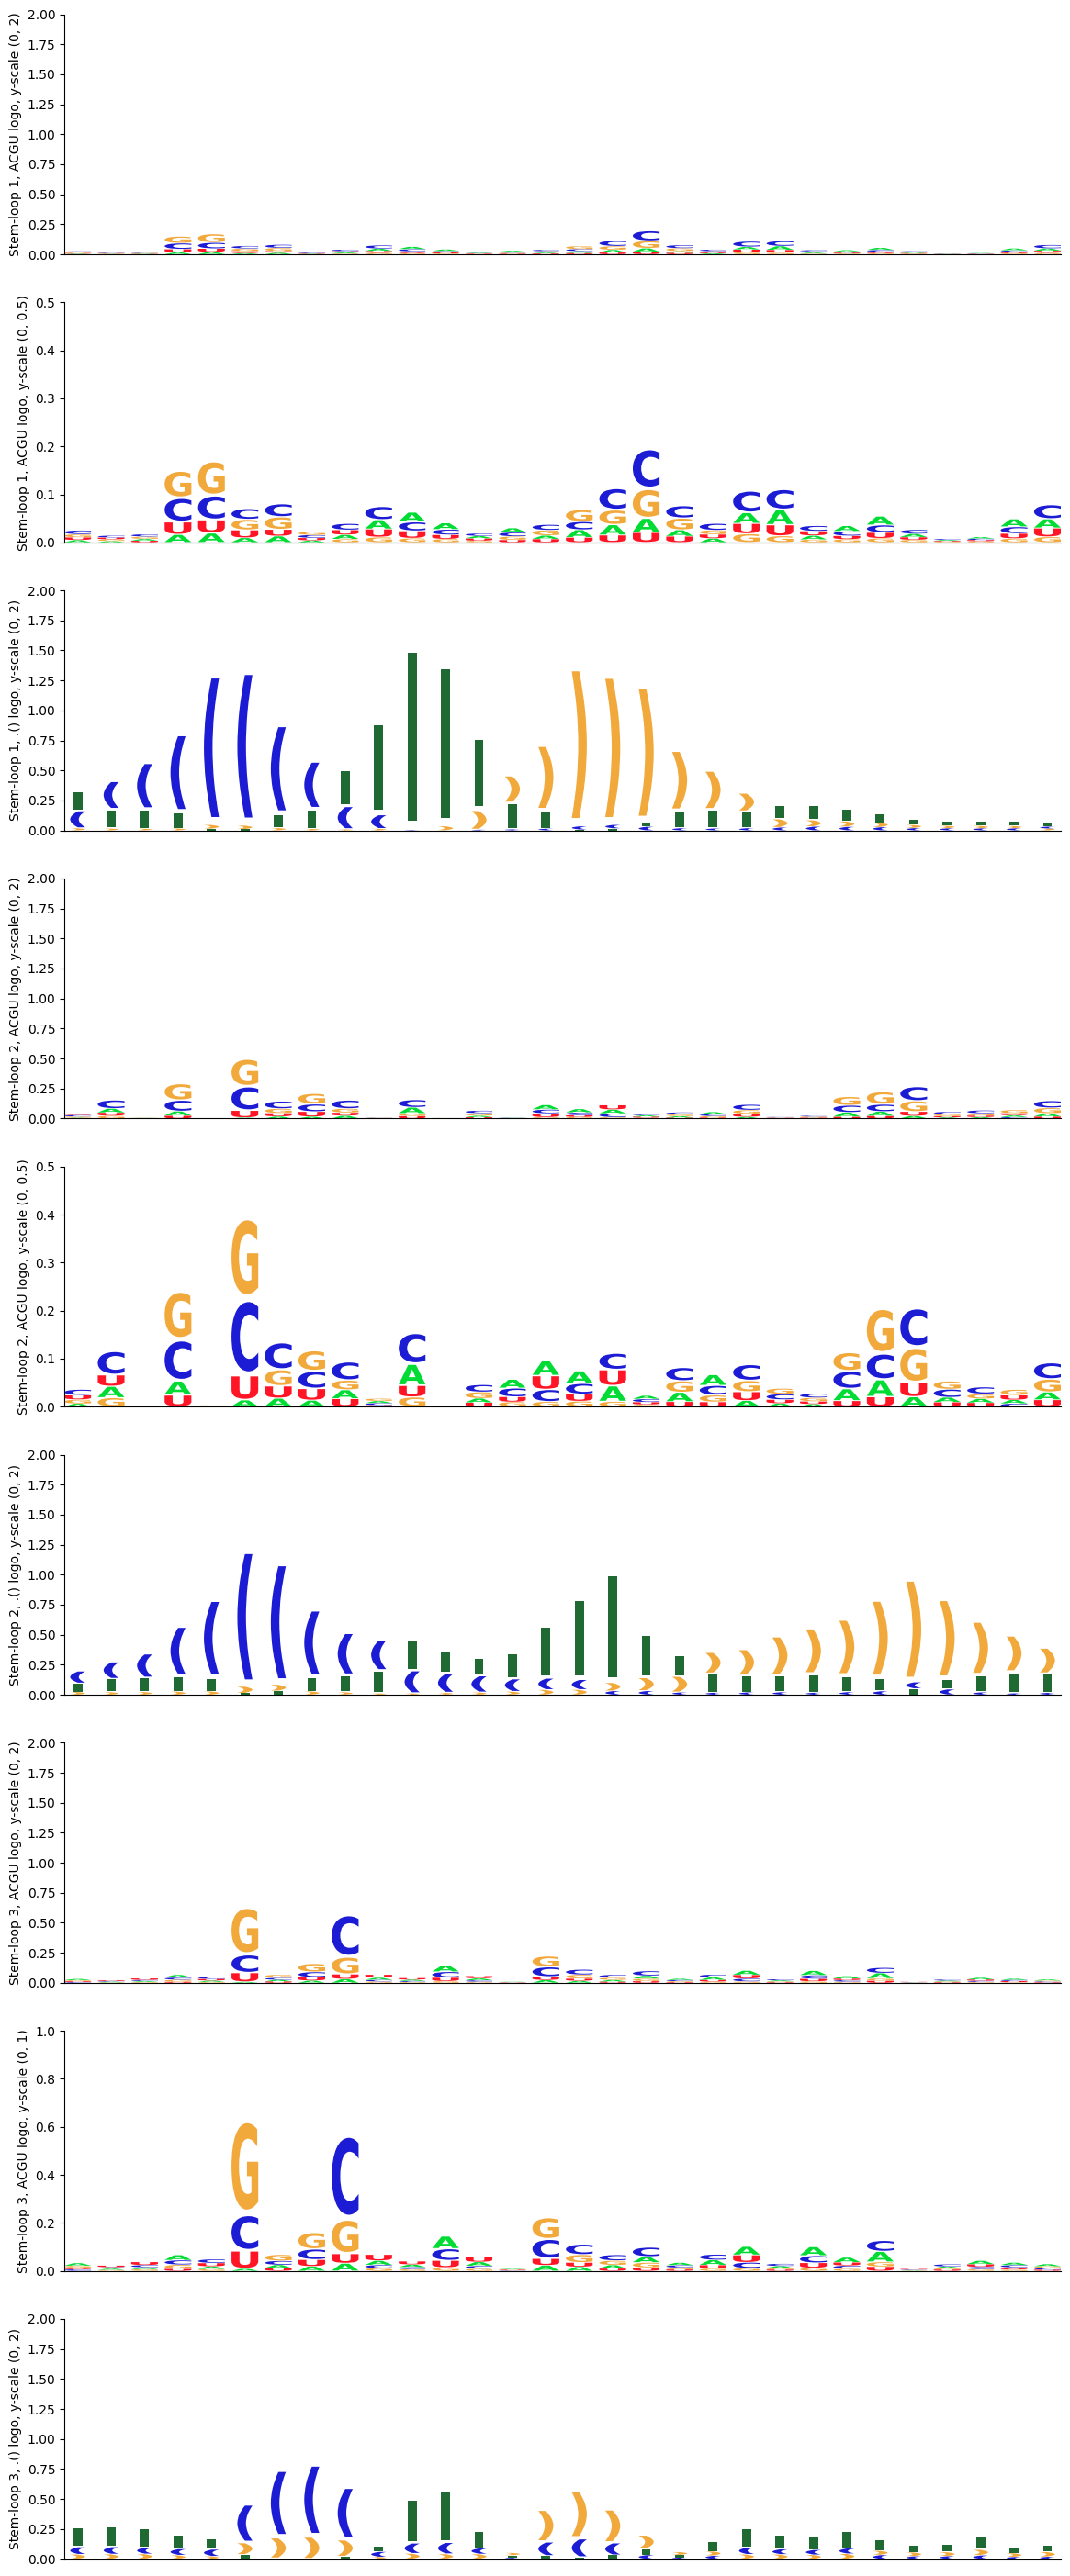

In [46]:
fig, axes = plt.subplots(9, 1, figsize=(14, 36))


df = acts_df[['input', f'f{skip_order[2]}']]
df.columns = ['input', 'activation']
df = df.reset_index()
sequence_logo.plot_logo(df, 2, axes[0])
axes[0].set_ylim(0, 2)
axes[0].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].spines["left"].set_visible(True)
axes[0].set_ylabel("Stem-loop 1, ACGU logo, y-scale (0, 2)")

df = acts_df[['input', f'f{skip_order[2]}']]
df.columns = ['input', 'activation']
df = df.reset_index()
sequence_logo.plot_logo(df, 2, axes[1])
axes[1].set_ylim(0, 0.5)
axes[1].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)
axes[1].spines["left"].set_visible(True)
axes[1].set_ylabel("Stem-loop 1, ACGU logo, y-scale (0, 0.5)")

dfS = acts_df_struct[['input', f'f{skip_order[2]}']]
dfS.columns = ['input', 'activation']
dfS = dfS.reset_index(drop=True)
sequence_logo.plot_logo(dfS, 1, axes[2], nts=['.', '(', ')'], color_map={".": "#1f6933", "(": "#1c1cd5", ")": "#f2a93c"})
axes[2].set_ylim(0, 2)
axes[2].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[2].spines["top"].set_visible(False)
axes[2].spines["right"].set_visible(False)
axes[2].spines["left"].set_visible(True)
axes[2].set_ylabel("Stem-loop 1, .() logo, y-scale (0, 2)")


df = acts_df[['input', f'f{skip_order[3]}']]
df.columns = ['input', 'activation']
df = df.reset_index()
sequence_logo.plot_logo(df, 3, axes[3])
axes[3].set_ylim(0, 2)
axes[3].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[3].spines["top"].set_visible(False)
axes[3].spines["right"].set_visible(False)
axes[3].spines["left"].set_visible(True)
axes[3].set_ylabel("Stem-loop 2, ACGU logo, y-scale (0, 2)")

df = acts_df[['input', f'f{skip_order[3]}']]
df.columns = ['input', 'activation']
df = df.reset_index()
sequence_logo.plot_logo(df, 2, axes[4])
axes[4].set_ylim(0, 0.5)
axes[4].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[4].spines["top"].set_visible(False)
axes[4].spines["right"].set_visible(False)
axes[4].spines["left"].set_visible(True)
axes[4].set_ylabel("Stem-loop 2, ACGU logo, y-scale (0, 0.5)")

dfS = acts_df_struct[['input', f'f{skip_order[3]}']]
dfS.columns = ['input', 'activation']
dfS = dfS.reset_index(drop=True)
sequence_logo.plot_logo(dfS, 1, axes[5], nts=['.', '(', ')'], color_map={".": "#1f6933", "(": "#1c1cd5", ")": "#f2a93c"})
axes[5].set_ylim(0, 2)
axes[5].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[5].spines["top"].set_visible(False)
axes[5].spines["right"].set_visible(False)
axes[5].spines["left"].set_visible(True)
axes[5].set_ylabel("Stem-loop 2, .() logo, y-scale (0, 2)")


df = acts_df[['input', f'f{skip_order[4]}']]
df.columns = ['input', 'activation']
df = df.reset_index()
sequence_logo.plot_logo(df, 2, axes[6])
axes[6].set_ylim(0, 2)
axes[6].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[6].spines["top"].set_visible(False)
axes[6].spines["right"].set_visible(False)
axes[6].spines["left"].set_visible(True)
axes[6].set_ylabel("Stem-loop 3, ACGU logo, y-scale (0, 2)")

df = acts_df[['input', f'f{skip_order[4]}']]
df.columns = ['input', 'activation']
df = df.reset_index()
sequence_logo.plot_logo(df, 2, axes[7])
axes[7].set_ylim(0, 1)
axes[7].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[7].spines["top"].set_visible(False)
axes[7].spines["right"].set_visible(False)
axes[7].spines["left"].set_visible(True)
axes[7].set_ylabel("Stem-loop 3, ACGU logo, y-scale (0, 1)")

dfS = acts_df_struct[['input', f'f{skip_order[4]}']]
dfS.columns = ['input', 'activation']
dfS = dfS.reset_index(drop=True)
sequence_logo.plot_logo(dfS, 1, axes[8], nts=['.', '(', ')'], color_map={".": "#1f6933", "(": "#1c1cd5", ")": "#f2a93c"})
axes[8].set_ylim(0, 2)
axes[8].tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=False)
axes[8].spines["top"].set_visible(False)
axes[8].spines["right"].set_visible(False)
axes[8].spines["left"].set_visible(True)
axes[8].set_ylabel("Stem-loop 3, .() logo, y-scale (0, 2)")

fig.savefig("../figures/stem_loop_reps.png", dpi=300)